In [315]:
from os import path
import seaborn as sn
import sys
sys.path.append(path.abspath('.'))
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from AnomalyDetection import anomalydetection
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-white')

## Load the dataset

In [260]:
# Load the dataset (6 csv files)
# Load the json file simultaneously, as we need to label the anomaly, and there are replicates in the timestamps
# Load the cpc and cpm files into different dataset
def load_file(anomaly, suffix):
    filepath = "./realAdExchange/"
    df = pd.DataFrame()
    
    for i in range(2, 5):
        filename = "exchange-" + str(i) + suffix
        cur = pd.read_csv(filepath + filename)
        cur['anomaly'] = 0
        cur.loc[cur.timestamp.isin(anomaly[filepath[2:] + filename]), 'anomaly'] = 1
        cur['dataset'] = filename
        df = df.append(cur)
    
    return df

with open('./labels.json') as f:
    anomaly = json.load(f)

df_cpc = load_file(anomaly, "_cpc_results.csv")
df_cpm = load_file(anomaly, "_cpm_results.csv")

In [261]:
df_cpc.head(5)

,timestamp,value,anomaly,dataset
0,2011-07-01 00:00:01,0.081965,0,exchange-2_cpc_results.csv
1,2011-07-01 01:00:01,0.098972,0,exchange-2_cpc_results.csv
2,2011-07-01 02:00:01,0.065314,0,exchange-2_cpc_results.csv
3,2011-07-01 03:00:01,0.070663,0,exchange-2_cpc_results.csv
4,2011-07-01 04:00:01,0.102490,0,exchange-2_cpc_results.csv


In [262]:
df_cpc.describe()

,value,anomaly
count,4805.000000,4805.000000
mean,0.107905,0.001457
std,0.091368,0.038144
min,0.023884,0.000000
25%,0.072492,0.000000
50%,0.097467,0.000000
75%,0.124019,0.000000
max,3.126852,1.000000


In [263]:
df_cpc.groupby('anomaly').count()

,timestamp,value,dataset
anomaly,,,
0,4798,4798,4798
1,7,7,7


In [264]:
df_cpm.head(5)

,timestamp,value,anomaly,dataset
0,2011-07-01 00:00:01,0.401048,0,exchange-2_cpm_results.csv
1,2011-07-01 01:00:01,0.392719,0,exchange-2_cpm_results.csv
2,2011-07-01 02:00:01,0.309996,0,exchange-2_cpm_results.csv
3,2011-07-01 03:00:01,0.212939,0,exchange-2_cpm_results.csv
4,2011-07-01 04:00:01,0.205801,0,exchange-2_cpm_results.csv


In [265]:
df_cpm.describe()

,value,anomaly
count,4805.000000,4805.000000
mean,0.543631,0.001457
std,0.517033,0.038144
min,0.000385,0.000000
25%,0.323628,0.000000
50%,0.489483,0.000000
75%,0.648013,0.000000
max,16.438200,1.000000


In [266]:
df_cpm.groupby('anomaly').count()

,timestamp,value,dataset
anomaly,,,
0,4798,4798,4798
1,7,7,7


In [267]:
df_cpc[df_cpc['anomaly'] == 1]

,timestamp,value,anomaly,dataset
325,2011-07-14 13:00:01,0.172900,1,exchange-2_cpc_results.csv
296,2011-07-14 10:15:01,0.905385,1,exchange-3_cpc_results.csv
438,2011-07-20 10:15:01,0.989074,1,exchange-3_cpc_results.csv
977,2011-08-13 10:15:01,0.332500,1,exchange-3_cpc_results.csv
367,2011-07-16 09:15:01,1.937843,1,exchange-4_cpc_results.csv
776,2011-08-02 12:15:01,0.239967,1,exchange-4_cpc_results.csv
1276,2011-08-23 08:15:01,3.126852,1,exchange-4_cpc_results.csv


## Plot the value based on the timestamp to view any pattern

In [268]:
df_cpc_sorted = df_cpc.sort_values(by = ['timestamp']).reset_index()
df_cpm_sorted = df_cpm.sort_values(by = ['timestamp']).reset_index()

In [269]:
df_cpc_sorted.head(5)

,index,timestamp,value,anomaly,dataset
0,0,2011-07-01 00:00:01,0.081965,0,exchange-2_cpc_results.csv
1,0,2011-07-01 00:15:01,0.102709,0,exchange-3_cpc_results.csv
2,0,2011-07-01 00:15:01,0.091795,0,exchange-4_cpc_results.csv
3,1,2011-07-01 01:00:01,0.098972,0,exchange-2_cpc_results.csv
4,1,2011-07-01 01:15:01,0.074414,0,exchange-4_cpc_results.csv


Text(0.5, 1.0, 'Time Series of CPC by date time')

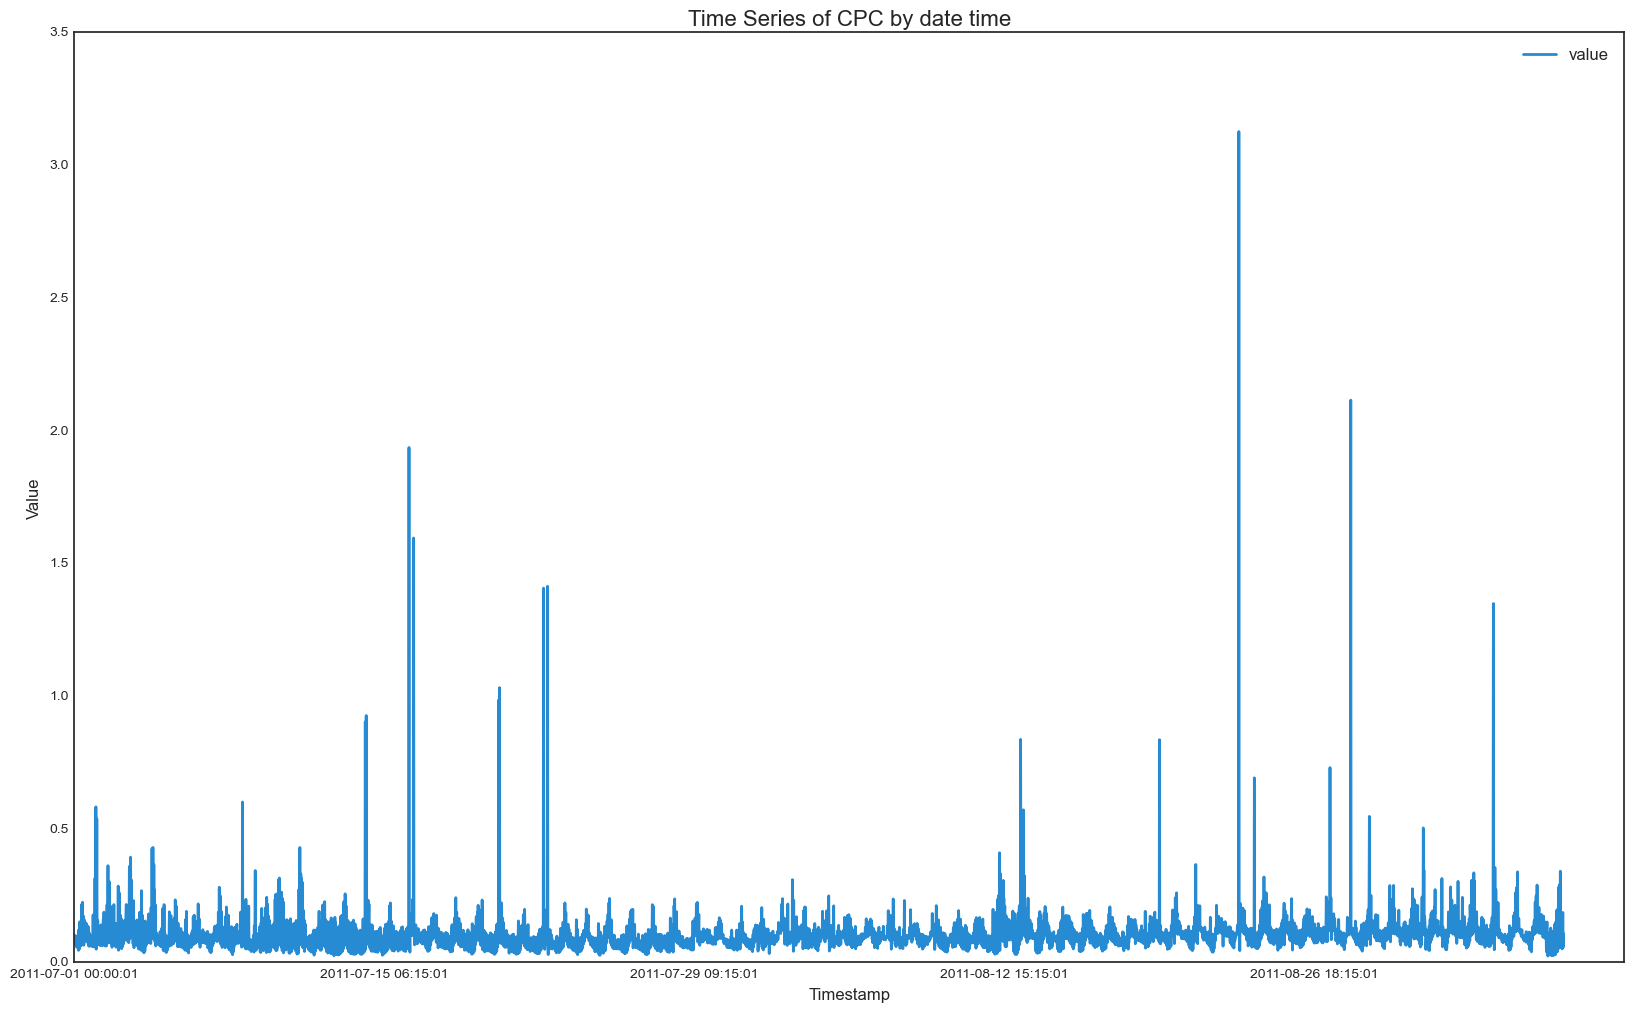

In [270]:
df_cpc_sorted.plot(x='timestamp', y='value', figsize = (20,12))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of CPC by date time')

Text(0.5, 1.0, 'Time Series of CPM by date time')

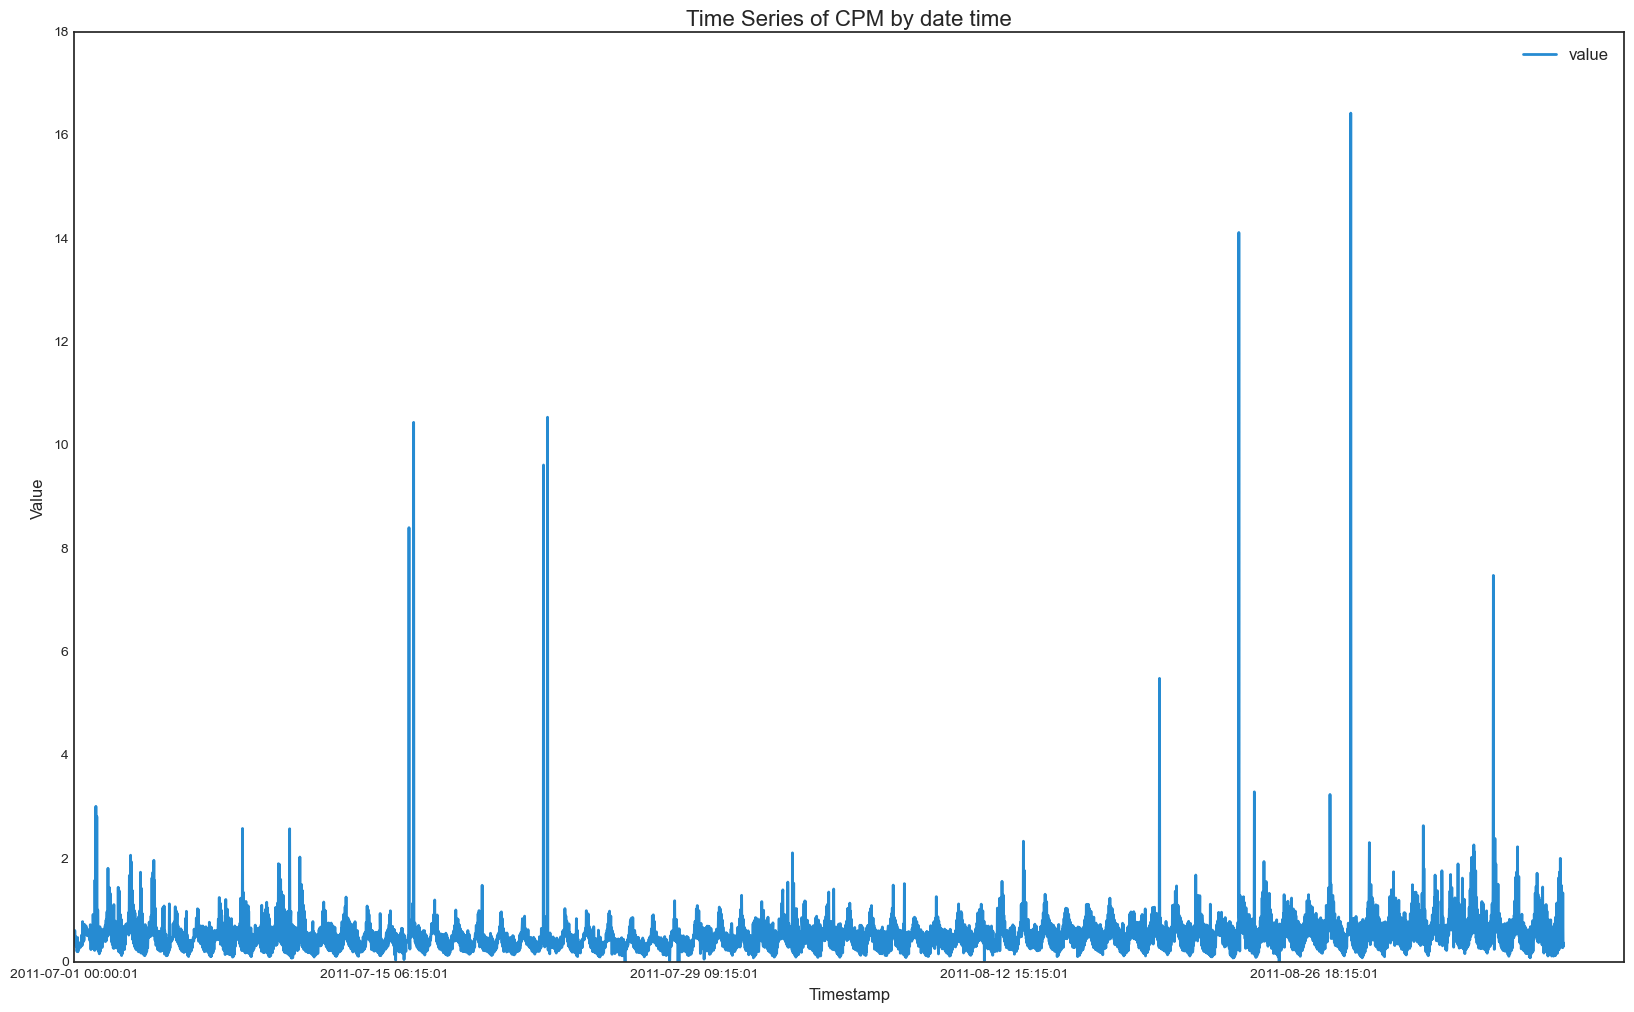

In [271]:
df_cpm_sorted.plot(x='timestamp', y='value', figsize = (20,12))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of CPM by date time')

Clearly, there is a pattern in the data. Thus, it is **NOT** correct to simply find the extreme data in the distribution. If we follow this way, some normal values will be misclassified. Instead, we need to use time series analysis in our anomaly detection.

## Algorithms (Using ARIMA)

### df_cpc_sorted

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4805
Model:                ARIMA(20, 2, 1)   Log Likelihood                4586.196
Date:                Wed, 17 Feb 2021   AIC                          -9128.393
Time:                        15:14:32   BIC                          -8985.899
Sample:                             0   HQIC                         -9078.349
                               - 4805                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0396      0.020    -50.908      0.000      -1.080      -1.000
ar.L2         -0.9973      0.038    -25.917      0.000      -1.073      -0.922
ar.L3         -0.8949      0.054    -16.501      0.0

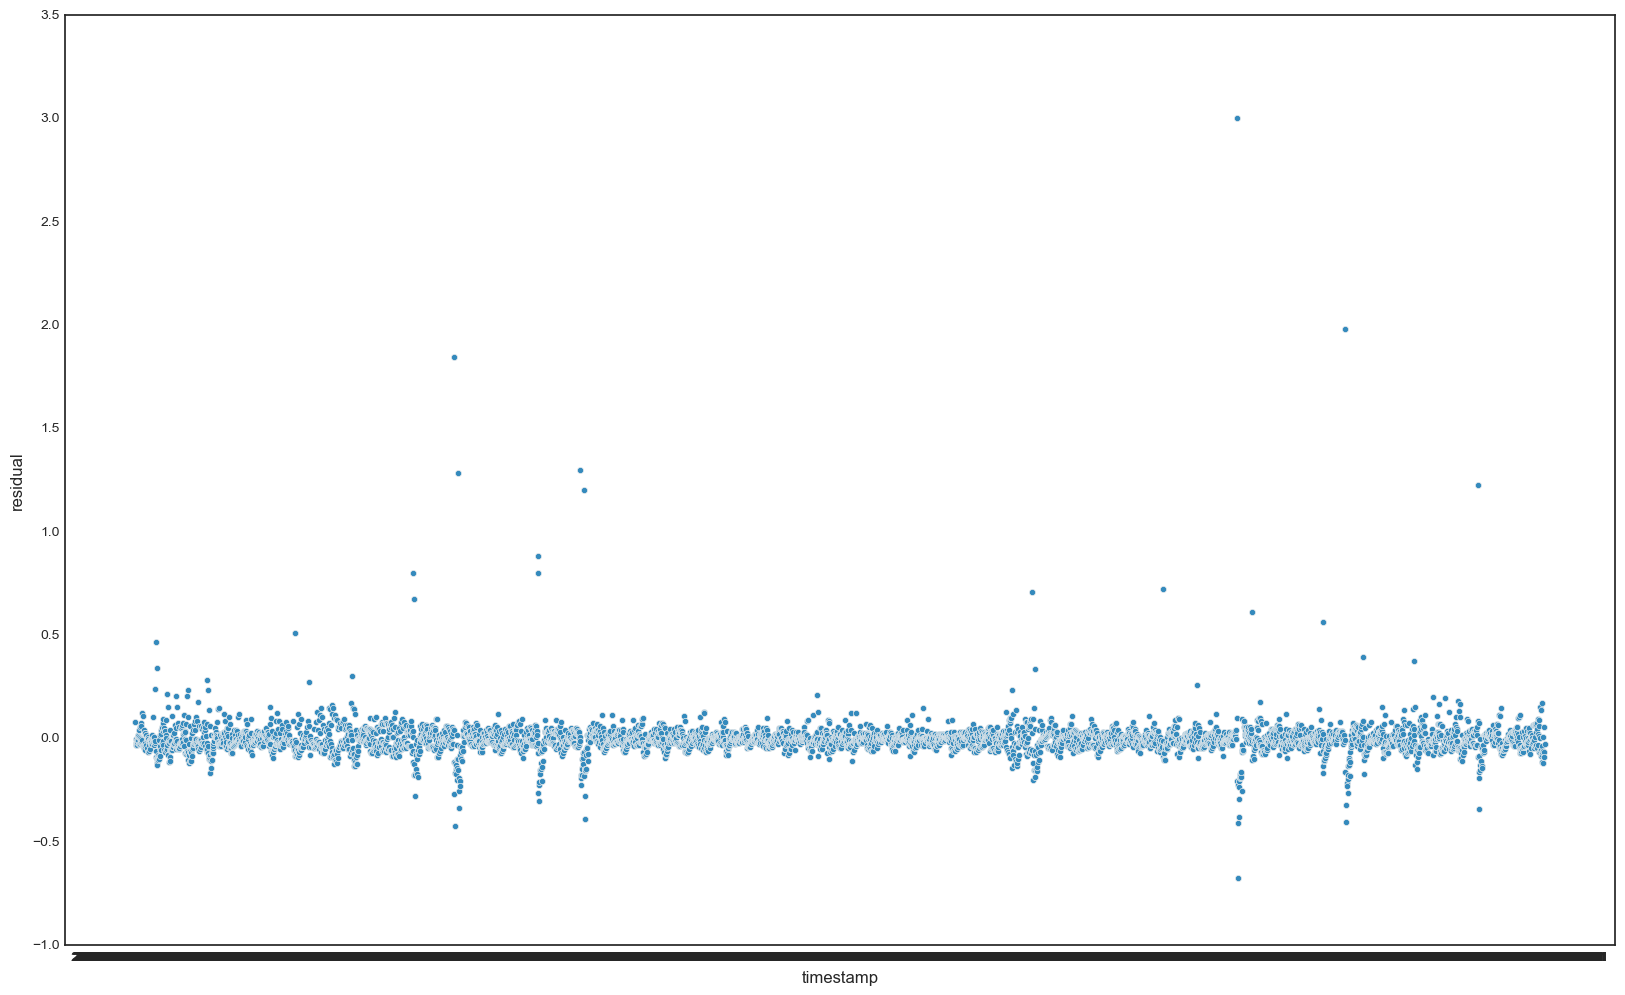

<Figure size 1200x600 with 0 Axes>

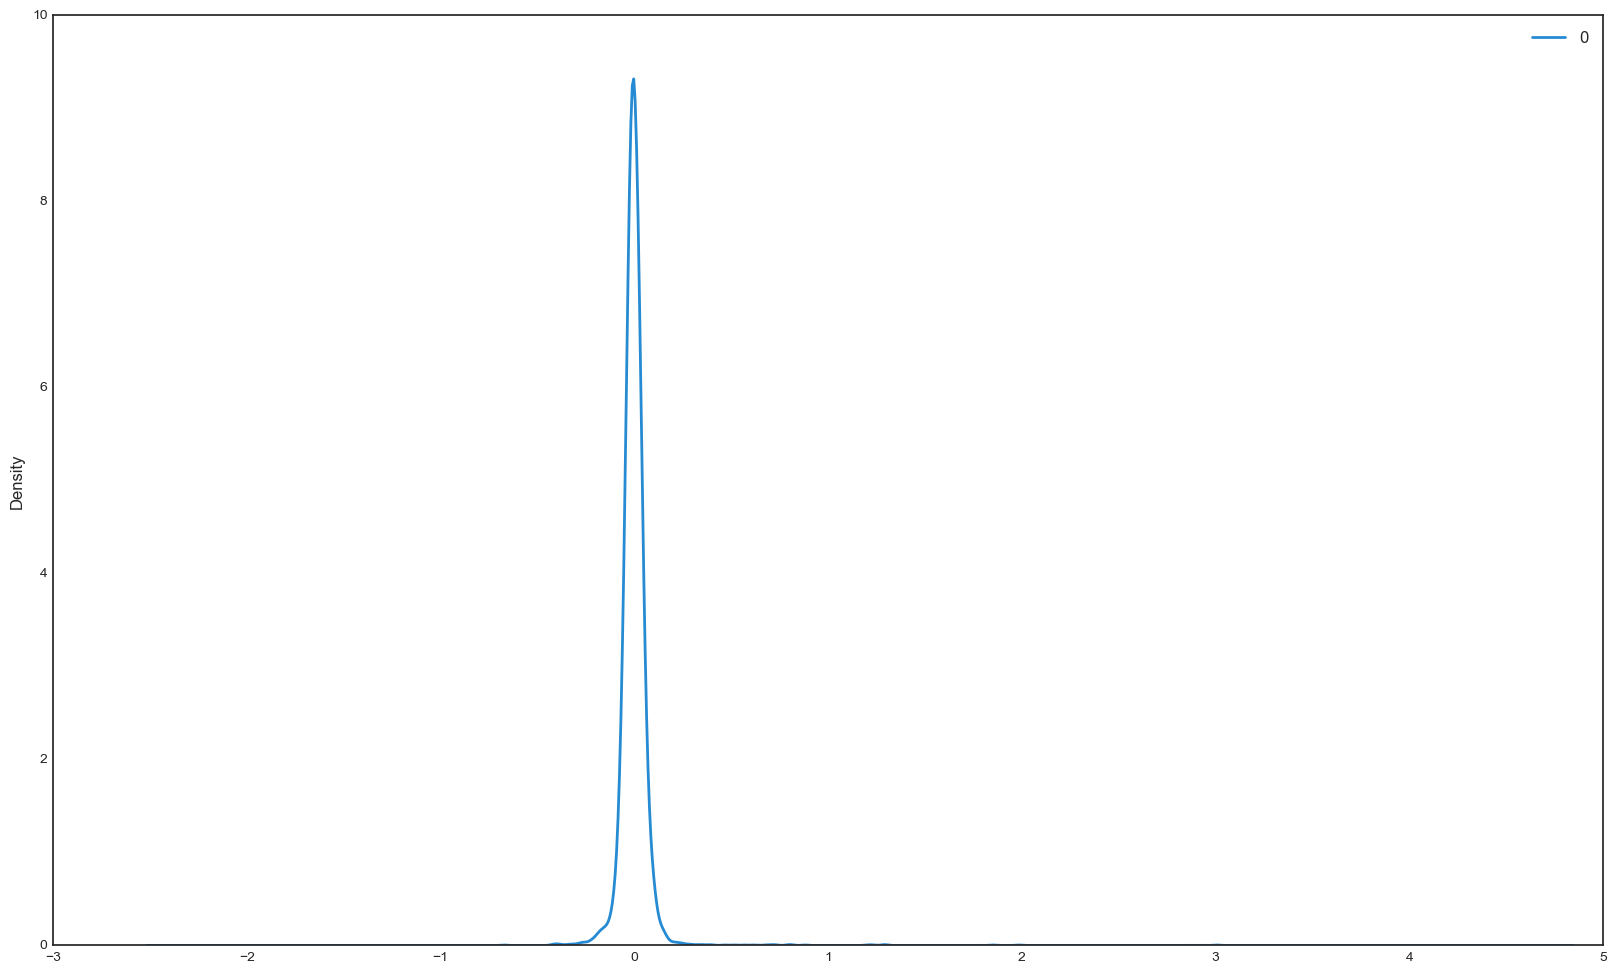

<Figure size 1200x600 with 0 Axes>

                 0
count  4805.000000
mean      0.000003
std       0.093057
min      -0.675236
25%      -0.029217
50%      -0.003787
75%       0.023677
max       3.003899


In [278]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df_cpc_sorted['value'], order=(20, 2, 1))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# plot of residuals
residuals = pd.DataFrame(model_fit.resid)
df_cpc_sorted['residual'] = list(residuals.loc[:,0])
df_cpc_sorted.plot.scatter(x = 'timestamp', y = 'residual')
plt.figure(figsize = (12, 6))
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde')
plt.figure(figsize = (12, 6))
plt.show()

# summary stats of residuals
print(residuals.describe())

In [282]:
df_cpc_sorted['predictedAnomaly'] = (abs(residuals) > 2)
df_cpc_sorted.loc[df_cpc_sorted['predictedAnomaly'] == False, 'predictedAnomaly'] = 0
df_cpc_sorted.loc[df_cpc_sorted['predictedAnomaly'] == True, 'predictedAnomaly'] = 1
df_cpc_sorted

,index,timestamp,value,anomaly,dataset,residual,predictedAnomaly
0,0,2011-07-01 00:00:01,0.081965,0,exchange-2_cpc_results.csv,0.081965,0
1,0,2011-07-01 00:15:01,0.102709,0,exchange-3_cpc_results.csv,-0.020238,0
2,0,2011-07-01 00:15:01,0.091795,0,exchange-4_cpc_results.csv,-0.031658,0
3,1,2011-07-01 01:00:01,0.098972,0,exchange-2_cpc_results.csv,-0.003361,0
4,1,2011-07-01 01:15:01,0.074414,0,exchange-4_cpc_results.csv,-0.030185,0
...,...,...,...,...,...,...,...
4800,1641,2011-09-07 13:15:01,0.050782,0,exchange-4_cpc_results.csv,-0.115671,0
4801,1622,2011-09-07 14:00:01,0.085386,0,exchange-2_cpc_results.csv,-0.061708,0
4802,1537,2011-09-07 14:15:01,0.188106,0,exchange-3_cpc_results.csv,0.054631,0
4803,1642,2011-09-07 14:15:01,0.056232,0,exchange-4_cpc_results.csv,-0.087007,0


### df_cpm_sorted

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4805
Model:                ARIMA(20, 2, 1)   Log Likelihood               -3539.466
Date:                Wed, 17 Feb 2021   AIC                           7122.932
Time:                        15:23:07   BIC                           7265.426
Sample:                             0   HQIC                          7172.976
                               - 4805                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9706      0.018    -55.260      0.000      -1.005      -0.936
ar.L2         -0.9090      0.020    -45.463      0.000      -0.948      -0.870
ar.L3         -0.7299      0.021    -34.100      0.0

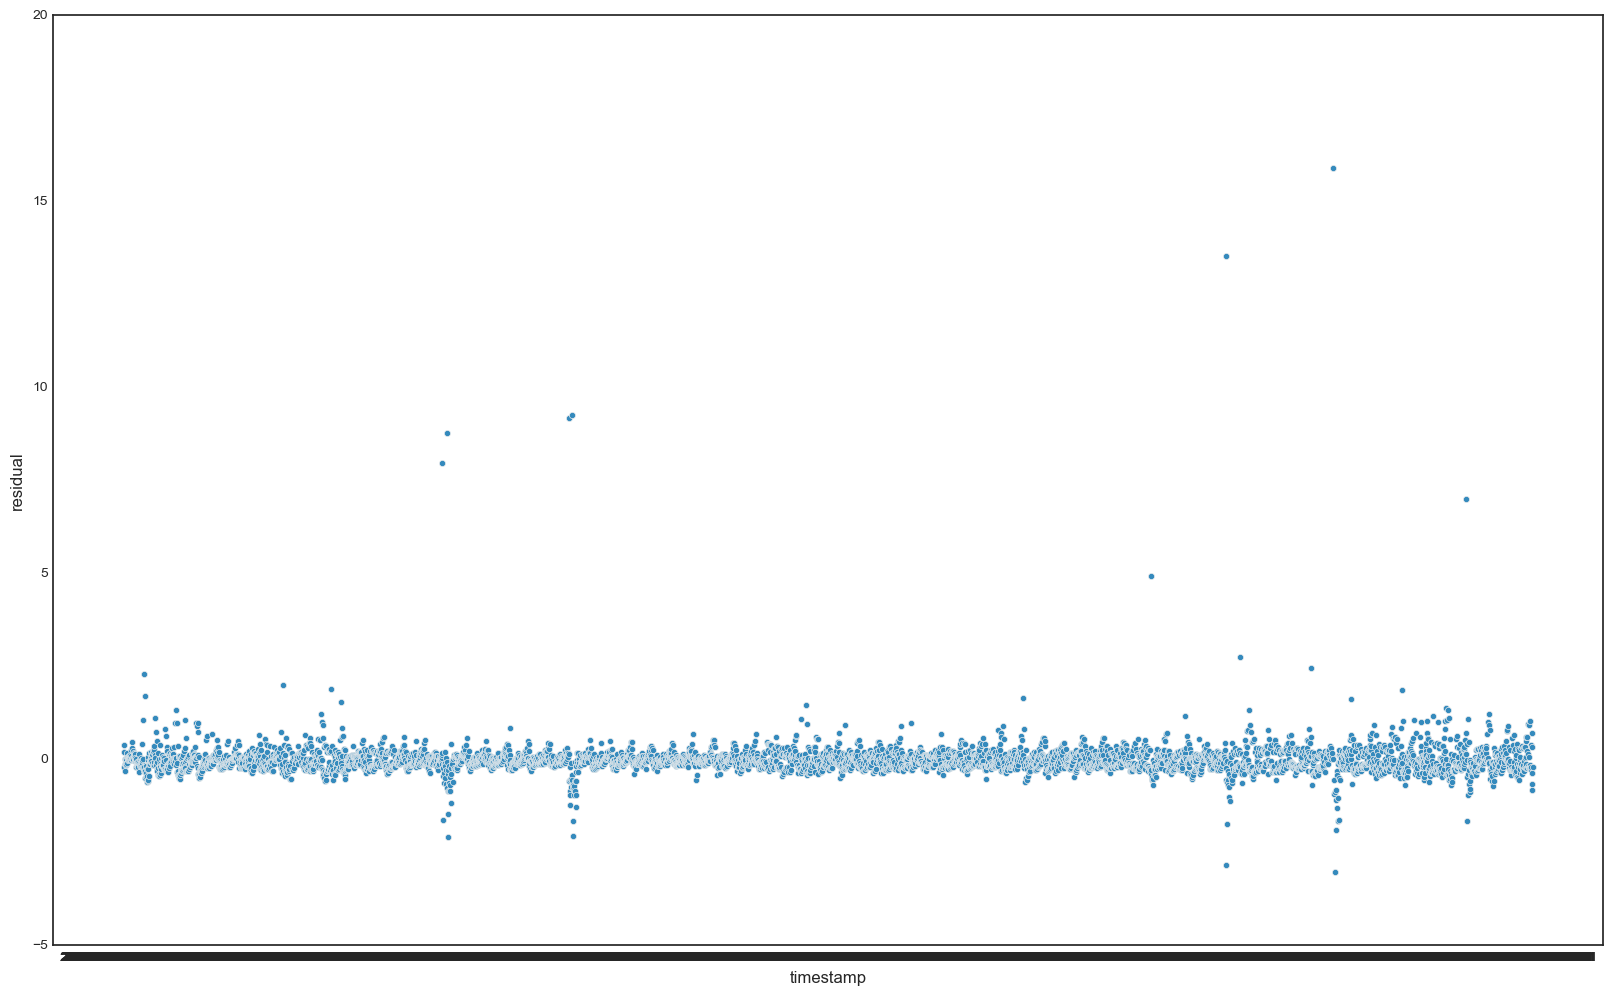

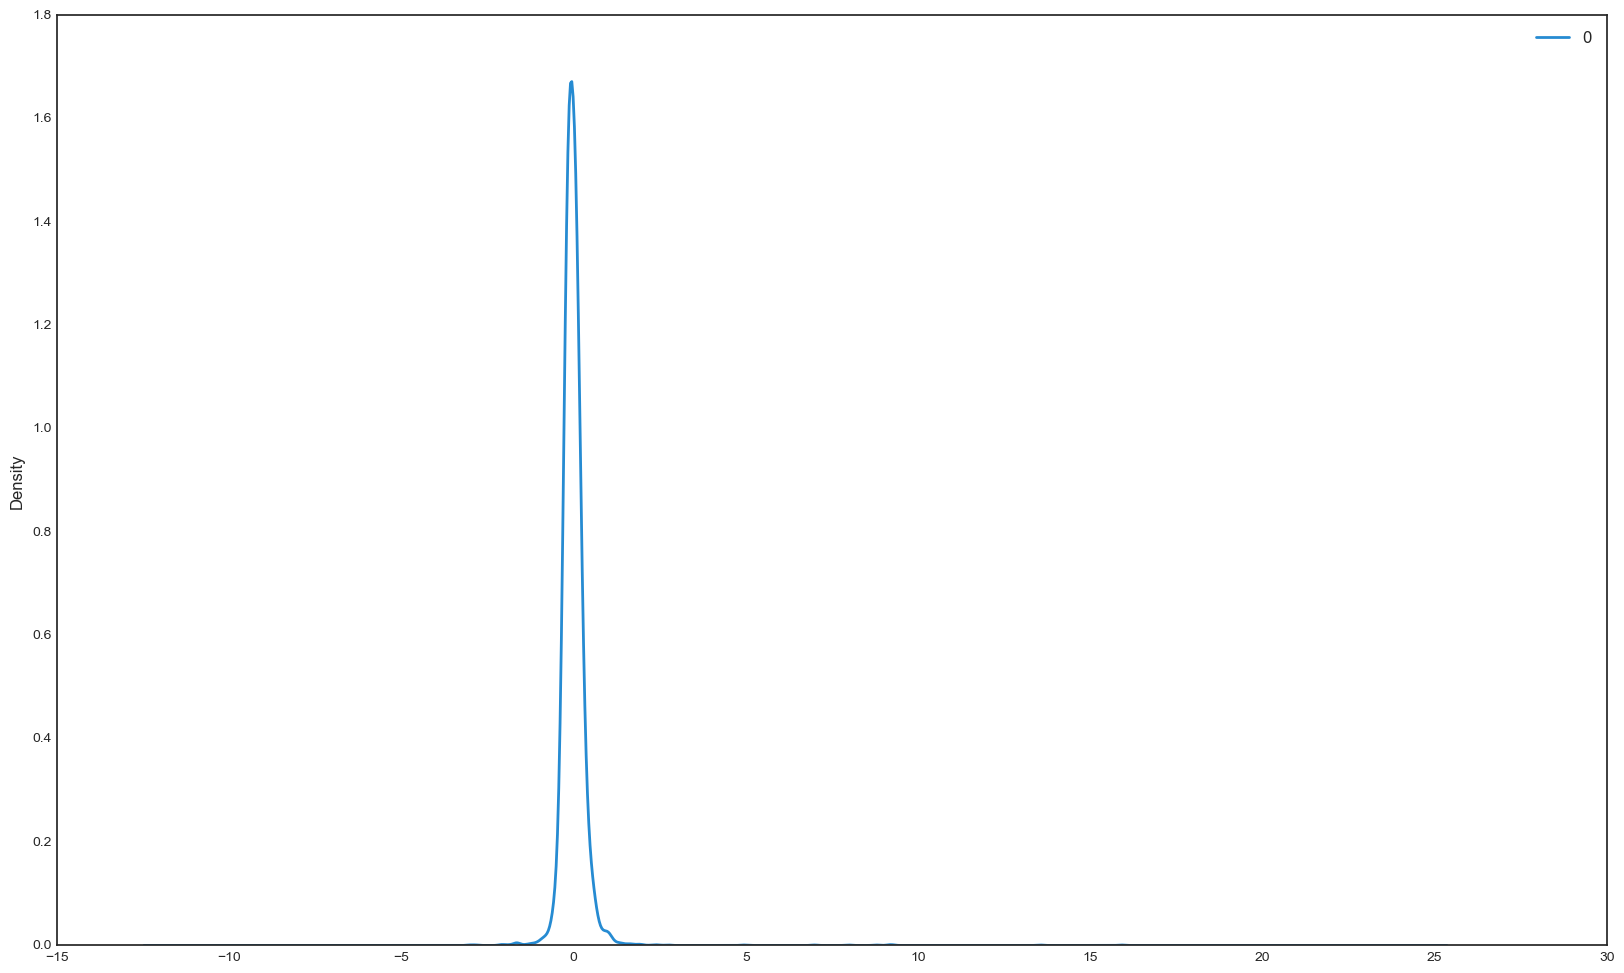

                 0
count  4805.000000
mean     -0.000681
std       0.505037
min      -3.015729
25%      -0.176654
50%      -0.035882
75%       0.115444
max      15.897931


In [284]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df_cpm_sorted['value'], order=(20, 2, 1))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
df_cpm_sorted['residual'] = list(residuals.loc[:,0])
df_cpm_sorted.plot.scatter(x = 'timestamp', y = 'residual')
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [285]:
df_cpm_sorted['predictedAnomaly'] = (abs(residuals) > 5)
df_cpm_sorted.loc[df_cpm_sorted['predictedAnomaly'] == False, 'predictedAnomaly'] = 0
df_cpm_sorted.loc[df_cpm_sorted['predictedAnomaly'] == True, 'predictedAnomaly'] = 1
df_cpm_sorted

,index,timestamp,value,anomaly,dataset,residual,predictedAnomaly
0,0,2011-07-01 00:00:01,0.401048,0,exchange-2_cpm_results.csv,0.401048,0
1,0,2011-07-01 00:15:01,0.405423,0,exchange-3_cpm_results.csv,-0.196150,0
2,0,2011-07-01 00:15:01,0.618226,0,exchange-4_cpm_results.csv,0.208429,0
3,1,2011-07-01 01:00:01,0.392719,0,exchange-2_cpm_results.csv,-0.302465,0
4,1,2011-07-01 01:15:01,0.506628,0,exchange-4_cpm_results.csv,0.008166,0
...,...,...,...,...,...,...,...
4800,1641,2011-09-07 13:15:01,0.287671,0,exchange-4_cpm_results.csv,-0.826541,0
4801,1622,2011-09-07 14:00:01,0.285779,0,exchange-2_cpm_results.csv,-0.368787,0
4802,1537,2011-09-07 14:15:01,1.346445,0,exchange-3_cpm_results.csv,0.721485,0
4803,1642,2011-09-07 14:15:01,0.299011,0,exchange-4_cpm_results.csv,-0.673026,0


## Build confusion matrix for 6 datasets

In [308]:
df_cpc_2 = df_cpc_sorted[df_cpc_sorted['dataset'] == 'exchange-2_cpc_results.csv']
df_cpc_3 = df_cpc_sorted[df_cpc_sorted['dataset'] == 'exchange-3_cpc_results.csv']
df_cpc_4 = df_cpc_sorted[df_cpc_sorted['dataset'] == 'exchange-4_cpc_results.csv']
df_cpm_2 = df_cpm_sorted[df_cpm_sorted['dataset'] == 'exchange-2_cpm_results.csv']
df_cpm_3 = df_cpm_sorted[df_cpm_sorted['dataset'] == 'exchange-3_cpm_results.csv']
df_cpm_4 = df_cpm_sorted[df_cpm_sorted['dataset'] == 'exchange-4_cpm_results.csv']

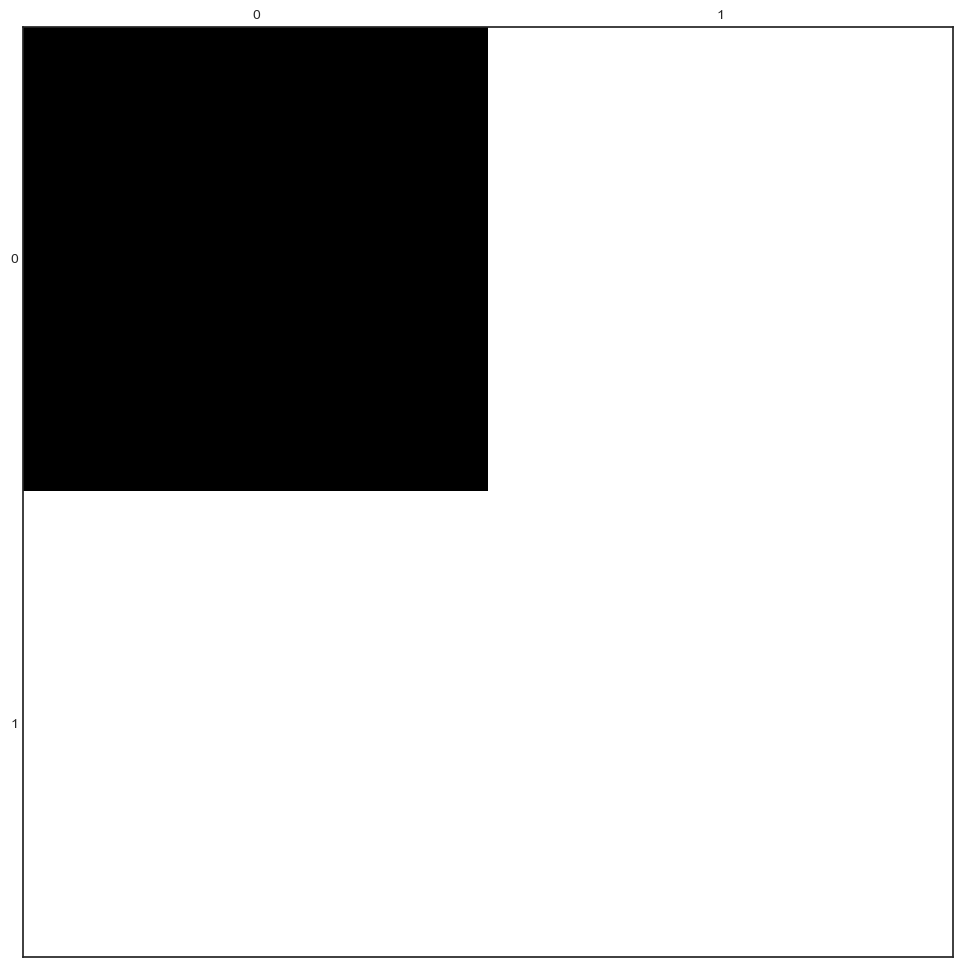

In [321]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# exchange-2_cpc_results.csv
actual = list(df_cpc_2['anomaly'])
predicted = list(df_cpc_2['predictedAnomaly'])
plt.matshow(confusion_matrix(actual, predicted))
df_cm = pd.DataFrame(confusion_matrix(actual, predicted), index = [i for i in range(0,2)],
#                  columns = [i for i in range(0,2)])
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)
plt.show()

In [310]:
# exchange-3_cpc_results.csv
actual = list(df_cpc_3['anomaly'])
predicted = list(df_cpc_3['predictedAnomaly'])
confusion_matrix(actual, predicted)

array([[1535,    0],
       [   3,    0]])

In [311]:
# exchange-4_cpc_results.csv
actual = list(df_cpc_4['anomaly'])
predicted = list(df_cpc_4['predictedAnomaly'])
confusion_matrix(actual, predicted)

array([[1640,    0],
       [   2,    1]])

In [312]:
# exchange-2_cpm_results.csv
actual = list(df_cpm_2['anomaly'])
predicted = list(df_cpm_2['predictedAnomaly'])
confusion_matrix(actual, predicted)

array([[1622,    0],
       [   2,    0]])

In [313]:
# exchange-3_cpm_results.csv
actual = list(df_cpm_3['anomaly'])
predicted = list(df_cpm_3['predictedAnomaly'])
confusion_matrix(actual, predicted)

array([[1537,    0],
       [   1,    0]])

In [314]:
# exchange-4_cpm_results.csv
actual = list(df_cpm_4['anomaly'])
predicted = list(df_cpm_4['predictedAnomaly'])
confusion_matrix(actual, predicted)

array([[1635,    4],
       [   1,    3]])

## Code Using Module

### df_cpc_sorted

In [ ]:
# fit model
model = anomalydetection.anomalydetection(df_cpc_sorted, (20, 2, 1), 2)
model_fit = model.fit()

# plot of residuals
model.residualInfo()

# get the residual and append it to the df_cpc_sorted dataframe
df_cpc_sorted['residual'] = model.getResidual()

# get the predictions of value
predicted = list(model_fit.getPrediction())

# prediction of whether the data is an anomaly
anomaly = model.predictAnomaly()

df_cpc_sorted['predictedAnomaly'] = anomaly
df_cpc_sorted.loc[df_cpc_sorted['predictedAnomaly'] == False, 'predictedAnomaly'] = 0
df_cpc_sorted.loc[df_cpc_sorted['predictedAnomaly'] == True, 'predictedAnomaly'] = 1
df_cpc_sorted

### df_cpm_sorted

In [ ]:
# fit model
model = anomalydetection.anomalydetection(df_cpm_sorted, (20, 2, 1), 5)
model_fit = model.fit()

# plot of residuals
model.residualInfo()

# get the residual and append it to the df_cpc_sorted dataframe
df_cpm_sorted['residual'] = model.getResidual()

# get the predictions of value
predicted = list(model_fit.getPrediction())

# prediction of whether the data is an anomaly
anomaly = model.predictAnomaly()
 
df_cpm_sorted['predictedAnomaly'] = anomaly
df_cpm_sorted.loc[df_cpm_sorted['predictedAnomaly'] == False, 'predictedAnomaly'] = 0
df_cpm_sorted.loc[df_cpm_sorted['predictedAnomaly'] == True, 'predictedAnomaly'] = 1
df_cpm_sorted